In [2]:
import os
# numerical computing package
import numpy as np
# 
from scipy import stats
# command style functions that make matplotlib work like MATLAB
import matplotlib.pyplot as plt
# matplotlib
import matplotlib
# find nearest value
def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()
#
import sys
#
import pickle
#
import xarray as xr
#
from glob import glob as gb
#
import time
#
import cartopy.crs as ccrs
#
from copy import deepcopy as cp

In [3]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [4]:
!pwd

/home/561/erd561/mom/gfdl_nyf_1080_rcp85


In [5]:
figures_path = '/home/561/erd561/figures/SAMexp/'
script_name = nb_name[:-6]
print('Figures will be saved in: ' + figures_path + script_name + '\n')

nyf_path = '/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/'
ctrl_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
hist5069_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
rcp85_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/'

Figures will be saved in: /home/561/erd561/figures/SAMexp/t10_dTdy



In [6]:
%%time

from dask.distributed import Client
c = Client()
print(c)

<Client: scheduler='tcp://127.0.0.1:45903' processes=8 cores=8>
CPU times: user 1.05 s, sys: 231 ms, total: 1.28 s
Wall time: 4.88 s


In [7]:
# ice_daily, ice_month, ocean_bgc_2d, ocean_bgc_carbon, ocean_bgc_daily,
# ocean_bgc_npzd, ocean_cfc, ocean_force, ocean_global, ocean_month, ocean_surface

nyf_years = np.arange(477, 487)
ctrl_years = np.arange(566, 576)
# hist5069_years = np.arange(501, 576)
rcp85_years = np.arange(611, 621)

nyf_years_len = len(nyf_years)
ctrl_years_len = len(ctrl_years)
# hist5069_years_len = len(hist5069_years)
rcp85_years_len = len(rcp85_years)

years = np.concatenate([
    np.arange(1-nyf_years_len, 0), 
    np.arange(0, ctrl_years_len+1), 
    np.arange(ctrl_years_len+1, ctrl_years_len+1 + rcp85_years_len)])
print(years)
print(len(years))

# 1. SST
var1 = 'ice_month'
path1 = []

# 2. tx and ty trans
var21 = 'ocean'
var22 = 'ocean_month'
path2 = []

# var31 = 'ocean'
# var32 = 'ocean_month'
# path3 = []

for y in nyf_years:
    path1.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
    path2.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
#     path3.append(remote_path_ctrl + 'output' + str(y) + '/' + var31 + '.nc')

for y in ctrl_years:
    path1.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
    path2.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')

for y in rcp85_years:
    path1.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
    path2.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')


for p1,p2 in zip(path1,path2):
    print(p1)
    print(p2)
#     print(p3)


[-9 -8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 15 16 17 18 19 20]
30
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc
/g/data/

In [8]:
%%time

lon = [100-360, 170-360]
lat = [-60, -20]

for p1,p2 in zip(path1, path2):
    if p1 == path1[0]:
        SST = \
            xr.open_dataset(p1, decode_times=False).\
            temp.\
            sel(xt_ocean=slice(lon[0], lon[1])).\
            sel(yt_ocean=slice(lat[0], lat[1])).\
            sel(st_ocean=0, method='nearest').\
            drop(('geolon_t', 'geolat_t')).\
            mean(dim='time')
        
        tau_x = \
            xr.open_dataset(p2, decode_times=False).\
            tau_x.\
            sel(xu_ocean=slice(lon[0], lon[1])).\
            sel(yu_ocean=slice(lat[0], lat[1])).\
            mean(dim='time').\
            drop(('geolon_c', 'geolat_c'))
        print(str(p1) + ' OK')
            
    elif 'v45' in p1:
        SST = \
            xr.concat([
                SST,
                xr.open_dataset(p1, decode_times=False).\
                temp.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                drop(('geolon_t', 'geolat_t')).\
                mean(dim='time')
            ], 'year'
            )
        
        tau_x = \
            xr.concat([
                tau_x,
                xr.open_dataset(p2, decode_times=False).\
                tau_x.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').\
                drop(('geolon_c', 'geolat_c'))
            ], 'year'
            )
        print(str(p1) + ' OK')
        
    else:
        SST = \
            xr.concat([
                SST,
                xr.open_dataset(p1, decode_times=False).\
                temp.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time')
            ], 'year'
            )
        tau_x = \
            xr.concat([
                tau_x,
                xr.open_dataset(p2, decode_times=False).\
                tau_x.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                mean(dim='time')
            ], 'year'
            )
        print(str(p1) + ' OK')
print(SST)

xt_ocean = SST.xt_ocean
xt_ocean_corrected = xt_ocean + 360
SST = SST.assign_coords(xt_ocean=xt_ocean_corrected)
xu_ocean = tau_x.xu_ocean
xu_ocean_corrected = xu_ocean + 360
tau_x = tau_x.assign_coords(xu_ocean=xu_ocean_corrected)

SST = SST.assign_coords(year=years)
tau_x = tau_x.assign_coords(year=years)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output484/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output485/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output486/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output566/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output567/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output568/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output569/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output570/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output571/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output572/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output573/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output574/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output575/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output611/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output612/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output613/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output614/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output615/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output616/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output617/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output618/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output619/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output620/ocean_month.nc OK
<xarray.DataArray 'temp' (year: 30, yt_ocean: 220, xt_ocean: 280)>
array([[[-0.401731, -0.380208, ...,  2.608085,  2.577984],
        [-0.406891, -0.376817, ...,  2.718419,  2.699332],
        ...,
        [23.918919, 23.935635, ..., 25.873558, 25.851952],
        [24.118069, 24.150646, ..., 26.02486 , 25.955761]],

       [[-0.469344, -0.446292, ...,  2.588118,  2.527822],
        [-0.461044, -0.434482, ...,  2.785284,  2.702575],
        ...,
        [23.966635, 23.966448, ..., 25.850706, 25.82425 ],
        [24.18553 , 24.199455, ..., 25.92586 , 25.899218]],

       ...,

       [[-0.440748, -0.452596, ...,  3.481239,  3.464719],
        [-0.406318, -0.394741, ...,  3.53492 ,  3.514677],
        ...,
        [24.305384, 24.327362, ..., 26.453362, 26.462786],
        [24.34794 , 24.386576, ..., 26.552256, 26.523329]],

       [[

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(219, 280)


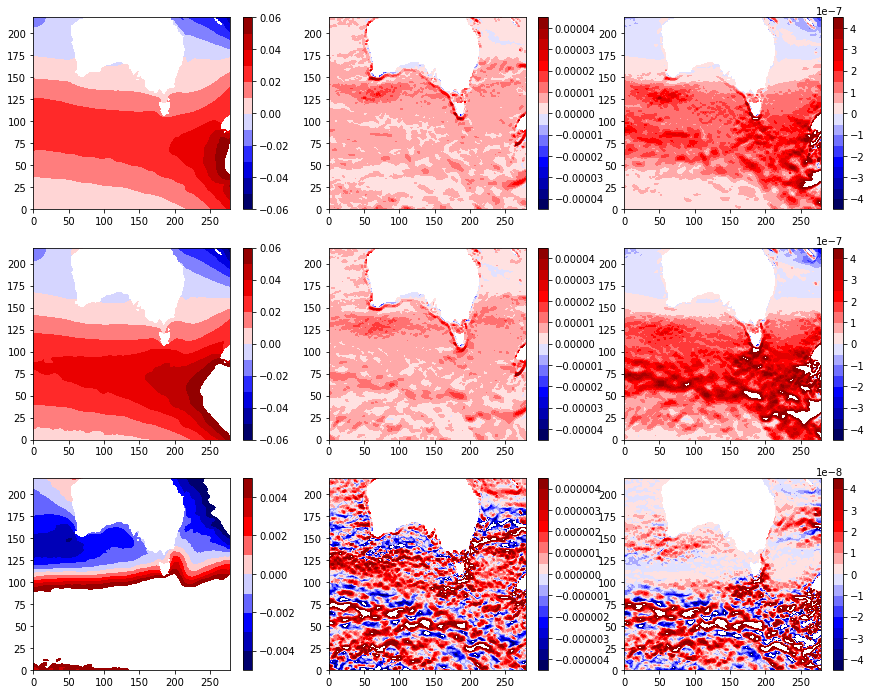

In [26]:
SST_nyf = SST.sel(year=slice(-9,0)).mean(dim='year')
SST_hist5069 = SST.sel(year=slice(1,10)).mean(dim='year')
SST_rcp85 = SST.sel(year=slice(11,20)).mean(dim='year')

tau_x_nyf = tau_x.sel(year=slice(-9,0)).mean(dim='year')
tau_x_hist5069 = tau_x.sel(year=slice(1,10)).mean(dim='year')
tau_x_rcp85 = tau_x.sel(year=slice(11,20)).mean(dim='year')

h_ek = 30
rho_0 = 1027
omega = 7.2921*10**-5
lat = tau_x_hist5069.xu_ocean
f = 2 * omega * np.sin(lat * np.pi / 180)
f = np.expand_dims(f, axis=0)
v_ek_hist5069 = tau_x_hist5069 / f / rho_0 / h_ek
v_ek_rcp85 = tau_x_rcp85 / f / rho_0 / h_ek
# print(v_ek_hist5069)

v_ek_hist5069 = v_ek_hist5069.sel(yu_ocean=slice(-59.90,-20.31))
v_ek_rcp85 = v_ek_rcp85.sel(yu_ocean=slice(-59.90,-20.31))

# print(SST.yt_ocean)

a = 6371000
pi180 = np.pi / 180
yt_ocean = SST.yt_ocean
dy = a * pi180 * \
(yt_ocean.sel(yt_ocean=slice(-59.84,-20.18)).data - \
 yt_ocean.sel(yt_ocean=slice(-59.97,-20.42)).data) 

dy = np.expand_dims(dy, axis=1)
# dy = np.expand_dims(dy, axis=2)
# print(dy)


dSST_hist5069 = SST_hist5069.sel(yt_ocean=slice(-59.84,-20.18)).data - \
SST_hist5069.sel(yt_ocean=slice(-59.97,-20.42)).data
dSST_rcp85 = SST_rcp85.sel(yt_ocean=slice(-59.84,-20.18)).data - \
SST_rcp85.sel(yt_ocean=slice(-59.97,-20.42)).data
# print(dSST_hist5069)
# print(dSST.shape)

dSSTdy_hist5069 = dSST_hist5069 / dy
dSSTdy_rcp85 = dSST_rcp85 / dy
print(dSSTdy_rcp85.shape)

# # print(v)
v_ek_hist5069_mid = v_ek_hist5069.interp(xu_ocean=SST.xt_ocean)
v_ek_rcp85_mid = v_ek_rcp85.interp(xu_ocean=SST.xt_ocean)
# print(v_ek_hist5069_mid)

meridional_heat_advection_hist5069 = v_ek_hist5069_mid * dSSTdy_hist5069
meridional_heat_advection_rcp85 = v_ek_rcp85_mid * dSSTdy_rcp85
# print(meridional_heat_advection_rcp85.shape)

def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)

fig = plt.figure()
fig.set_size_inches(2*7.5,12)

plt.subplot(3,3,1)
plt.contourf(v_ek_hist5069_mid, cmap = plt.cm.seismic, levels = arange(-0.06,0.06,0.01))
plt.colorbar()

plt.subplot(3,3,2)
plt.contourf(dSSTdy_hist5069, cmap = plt.cm.seismic, levels = arange(-0.000045,0.000045,0.000005))
plt.colorbar()

plt.subplot(3,3,3)
plt.contourf(meridional_heat_advection_hist5069, cmap = plt.cm.seismic, 
             levels = arange(-0.00000045,0.00000045,0.00000005))
plt.colorbar()


plt.subplot(3,3,4)
plt.contourf(v_ek_rcp85_mid, cmap = plt.cm.seismic, levels = arange(-0.06,0.06,0.01))
plt.colorbar()

plt.subplot(3,3,5)
plt.contourf(dSSTdy_rcp85, cmap = plt.cm.seismic, levels = arange(-0.000045,0.000045,0.000005))
plt.colorbar()

plt.subplot(3,3,6)
plt.contourf(meridional_heat_advection_rcp85, cmap = plt.cm.seismic, 
             levels = arange(-0.00000045,0.00000045,0.00000005))
plt.colorbar()


plt.subplot(3,3,7)
plt.contourf(v_ek_rcp85_mid - v_ek_hist5069_mid, cmap = plt.cm.seismic, levels = arange(-0.005,0.005,0.001))
plt.colorbar()

plt.subplot(3,3,8)
plt.contourf(dSSTdy_rcp85 - dSSTdy_hist5069, cmap = plt.cm.seismic, levels = arange(-0.0000045,0.0000045,0.0000005))
plt.colorbar()

plt.subplot(3,3,9)
# plt.contourf(meridional_heat_advection_rcp85 - meridional_heat_advection_hist5069, cmap = plt.cm.seismic, 
#              levels = arange(-0.00000045,0.00000045,0.00000005))
plt.contourf(
    (v_ek_rcp85_mid - v_ek_hist5069_mid) * (dSSTdy_rcp85 - dSSTdy_hist5069), cmap = plt.cm.seismic, 
             levels = arange(-0.000000045,0.00000004,0.000000005))
plt.colorbar()

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth', 'color'
  s)


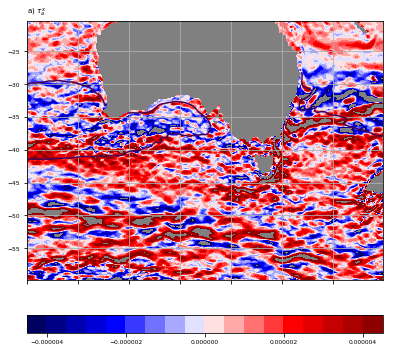

In [55]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)

fig = plt.figure() 
fig.set_size_inches(2*5,2*2.5)
matplotlib.rcParams.update({'font.size': 6}) 
col = 2
row = 1

ax = plt.subplot2grid((row, col), (0, 0), rowspan=1, colspan=1)

plt.contourf(SST.xt_ocean, 
             tau_x.yu_ocean.sel(yu_ocean=slice(-59.90,-20.31)), 
             dSSTdy_rcp85 - dSSTdy_hist5069, 
             cmap = plt.cm.seismic, levels = arange(-0.0000045,0.0000045,0.0000005))
plt.colorbar(orientation='horizontal', pad=0.1, ticks = arange(-0.000004,0.000004,0.000002))

plt.contour(v_ek_rcp85_mid.xu_ocean, v_ek_rcp85_mid.yu_ocean, v_ek_rcp85_mid - v_ek_hist5069_mid, 
            levels=[-0.002], linewidth=1, color='k')
# plt.contour(SST_rcp85.xt_ocean, SST_rcp85.yt_ocean, SST_rcp85 - SST_hist5069, 
#             levels=[0.25], linewidth=50, color='k')

plt.grid()
plt.title(r'a) $\tau^{x}_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_xticks(arange(100,160,10))
plt.gca().set_xticklabels('')
ax.set_facecolor('gray')



# ax = plt.subplot2grid((row, col), (0, 1), rowspan=1, colspan=1)
# cont_lev = arange(-2,2,0.25)
# anom = SST_rcp85 - SST_hist5069

# plt.contourf(SST.xt_ocean, 
#              tau_x.yu_ocean.sel(yu_ocean=slice(-59.90,-20.31)), 
#     (v_ek_rcp85_mid - v_ek_hist5069_mid) * (dSSTdy_rcp85 - dSSTdy_hist5069), cmap = plt.cm.seismic, 
#              levels = arange(-0.000000045,0.00000004,0.000000005))
# plt.colorbar(orientation='horizontal', pad=0.1, ticks = arange(-0.000004,0.000004,0.000002))

# plt.contour(SST_rcp85.xt_ocean, SST_rcp85.yt_ocean, SST_rcp85 - SST_hist5069, 
#             levels=[0.25], linewidth=1, color='k')

# plt.title('')
# plt.grid()
# plt.title('b) $SST_{a}$', loc='left')
# plt.xlabel('')
# plt.ylabel('')
# ax.set_facecolor('gray')
# plt.gca().set_xticks(arange(100,160,10))
# plt.gca().set_xticklabels('')
# plt.gca().set_yticklabels('')



# ax = plt.subplot2grid((row, col), (0, 2), rowspan=1, colspan=1)
# cont_lev = arange(-15,15,2.5)
# anom = sea_level_rcp85 - sea_level_hist5069
# contf = anom.plot.contourf(add_colorbar=True, levels=cont_lev, cmap=plt.cm.BrBG, extend='both',
#                           cbar_kwargs={'orientation':'horizontal',
#                                       'label': r'$cm$', 'pad':0.1})
# plt.title('')
# plt.grid()
# plt.title(r'c) $\eta_{a}$', loc='left')
# plt.xlabel('')
# plt.ylabel('')
# plt.gca().set_xticks(arange(100,160,10))
# plt.gca().set_xticklabels('')
# ax.set_facecolor('gray')
# plt.gca().set_yticklabels('')


fig.tight_layout(pad=0, w_pad=-2.5, h_pad=-0.5)

# output_ls = os.listdir(figures_path)
# if not script_name:
#     script_name = 'test'
# elif script_name not in output_ls:
#     os.mkdir(figures_path + '/' + script_name)
# plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
#             + '_fig1_.png', bbox_inches='tight', dpi=300)

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)

fig = plt.figure() 
fig.set_size_inches(7.5,12)
matplotlib.rcParams.update({'font.size': 6}) 
col = 3
row = 5

ax = plt.subplot2grid((row, col), (0, 0), rowspan=1, colspan=1)
cont_lev = arange(-0.03,0.03,0.005)
anom = tau_x_rcp85 - tau_x_hist5069
contf = anom.plot.contourf(add_colorbar=True, levels=cont_lev, cmap=plt.cm.PRGn, extend='both',
                          cbar_kwargs={'ticks': [-0.03, -0.015, 0, 0.015, 0.03],
                                      'orientation':'horizontal',
                                      'label': r'$N\ m^{-2}$', 'pad':0.1})
plt.grid()
plt.title(r'a) $\tau^{x}_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_xticklabels('')
ax.set_facecolor('gray')



ax = plt.subplot2grid((row, col), (0, 1), rowspan=1, colspan=1)
cont_lev = arange(-2,2,0.25)
anom = SST_rcp85 - SST_hist5069
contf = anom.plot.contourf(add_colorbar=True, levels=cont_lev, cmap=plt.cm.seismic, extend='both',
                          cbar_kwargs={'orientation':'horizontal',
                                      'label': r'$^{\circ}C$', 'pad':0.1})
plt.title('')
plt.grid()
plt.title('b) $SST_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')



ax = plt.subplot2grid((row, col), (0, 2), rowspan=1, colspan=1)
cont_lev = arange(-15,15,2.5)
anom = sea_level_rcp85 - sea_level_hist5069
contf = anom.plot.contourf(add_colorbar=True, levels=cont_lev, cmap=plt.cm.BrBG, extend='both',
                          cbar_kwargs={'orientation':'horizontal',
                                      'label': r'$cm$', 'pad':0.1})
plt.title('')
plt.grid()
plt.title(r'c) $\eta_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_xticklabels('')
ax.set_facecolor('gray')
plt.gca().set_yticklabels('')



ax = plt.subplot2grid((row, col), (1, 0), rowspan=1, colspan=1)
cont_lev = arange(-0.2,0.2,0.04)
anom = V_ek_rcp85 - V_ek_hist5069
contf = anom.plot.contourf(add_colorbar=True, levels=cont_lev, cmap=plt.cm.seismic, extend='both',
                          cbar_kwargs={'orientation':'horizontal',
                                      'label': r'$m^{2}\ s^{-1}$', 'pad':0.1})
plt.title('')
plt.grid()
plt.title(r'd) $V_{ek}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
# plt.gca().set_xticklabels('')
# plt.gca().set_yticklabels('')



ax = plt.subplot2grid((row, col), (1, 1), rowspan=1, colspan=1)
cont_lev = arange(-30,30,5)
anom = net_sfc_heating_rcp85 - net_sfc_heating_hist5069
contf = anom.plot.contourf(add_colorbar=True, levels=cont_lev, cmap=plt.cm.seismic, extend='both',
                          cbar_kwargs={'orientation':'horizontal',
                                      'label': r'$W\ m{-2}$', 'pad':0.1})
plt.title('')
plt.grid()
plt.title(r'e) $Q_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
# plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')



ax = plt.subplot2grid((row, col), (1, 2), rowspan=1, colspan=1)
cont_lev = arange(-0.00000005,0.00000005,0.00000001)
anom = tau_curl_rcp85 - tau_curl_hist5069
contf2 = anom.plot.contourf(add_colorbar=True, levels=cont_lev, cmap=plt.cm.seismic, extend='both',
                          cbar_kwargs={'orientation':'horizontal',
                                      'label': r'$N\ m^{-3}$', 'pad':0.1})
plt.title('')
plt.grid()
plt.title(r'f) $\nabla\ \times\ \tau_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
# plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')
ax.set_facecolor('gray')



ax = plt.subplot2grid((row, col), (2, 0), rowspan=2, colspan=2)
cont_lev = arange(-6, 6, 1)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [100, 147]
Y_LIM = [-47, -20]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Y = v_anom.yu_ocean[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
U = np.array(u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
V = np.array(v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
speed = np.sqrt(U**2 + V**2)
contf = plt.contourf(X, Y, V, add_colorbar=False, 
                     levels=cont_lev, cmap=plt.cm.coolwarm, extend='both')

anom = sea_level_rcp85 - sea_level_hist5069
X = anom.xt_ocean[
    find_nearest_index(anom.xt_ocean.data, X_LIM[0]):find_nearest_index(anom.xt_ocean.data, X_LIM[1])]
Y = anom.yt_ocean[
    find_nearest_index(anom.yt_ocean.data, Y_LIM[0]):find_nearest_index(anom.yt_ocean.data, Y_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
ANOM = np.array(anom[
    find_nearest_index(anom.yt_ocean.data, Y_LIM[0]):find_nearest_index(anom.yt_ocean.data, Y_LIM[1]),
    find_nearest_index(anom.xt_ocean.data, X_LIM[0]):find_nearest_index(anom.xt_ocean.data, X_LIM[1])
])

for l in arange(1, 7, 1):
    CS = plt.contour(X, Y, ANOM, colors='k', levels=[l], linewidths=l/5)
    plt.clabel(CS, inline=3, fontsize=7, fmt='%1.0f')

for l in arange(-4, -1, 1):
    CS = plt.contour(X, Y, ANOM, colors='k', levels=[l], linewidths=abs(l)/2.5, linestyles='--')
    plt.clabel(CS, inline=3, fontsize=7, fmt='%1.0f')


plt.title('')
plt.grid()
plt.title('g) $v_{a}$ and $\eta_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
ax = plt.subplot2grid((row, col), (4, 0), rowspan=1, colspan=2)
ax_divider = make_axes_locatable(ax)
cax1 = ax_divider.append_axes("top", size="7%", pad="2%")
cbar = plt.colorbar(contf, cax=cax1, orientation='horizontal', drawedges=True)
cbar.set_label(r'$cm\ s^{-1}$') 
cbar.ax.set_title('$v_{a}$')
# cax2 = ax_divider.append_axes("top", size="12%", pad="80%")
# cbar = plt.colorbar(Q2, cax=cax2, orientation='horizontal', drawedges=True, extend='max')
# cbar.set_ticks(Q_lev)
# cbar.set_label(r'$cm\ s^{-1}$')
# cbar.ax.set_title('$Speed_{a}$ (only for $|u_{a}| > ' + str(tol) + '\ cm\ s^{-1}$)')
ax.axis('off')


ax = plt.subplot2grid((row, col), (2, 2), rowspan=2, colspan=1)
cont_lev = arange(-24, 24, 4)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [147, 170]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Y = v_anom.yu_ocean[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
U = np.array(u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
V = np.array(v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
speed = np.sqrt(U**2 + V**2)
contf = plt.contourf(X, Y, V, add_colorbar=False, levels=cont_lev, cmap=plt.cm.coolwarm, extend='both')

anom = sea_level_rcp85 - sea_level_hist5069
X = anom.xt_ocean[
    find_nearest_index(anom.xt_ocean.data, X_LIM[0]):find_nearest_index(anom.xt_ocean.data, X_LIM[1])]
Y = anom.yt_ocean[
    find_nearest_index(anom.yt_ocean.data, Y_LIM[0]):find_nearest_index(anom.yt_ocean.data, Y_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
ANOM = np.array(anom[
    find_nearest_index(anom.yt_ocean.data, Y_LIM[0]):find_nearest_index(anom.yt_ocean.data, Y_LIM[1]),
    find_nearest_index(anom.xt_ocean.data, X_LIM[0]):find_nearest_index(anom.xt_ocean.data, X_LIM[1])
])

for l in arange(2, 10, 2):
    CS = plt.contour(X, Y, ANOM, colors='k', levels=[l], linewidths=l/20)
    plt.clabel(CS, inline=3, fontsize=7, fmt='%1.0f')

CS = plt.contour(X, Y, ANOM, colors='k', levels=[15], linewidths=1)
plt.clabel(CS, inline=3, fontsize=7, fmt='%1.0f')
CS = plt.contour(X, Y, ANOM, colors='k', levels=[25], linewidths=1.5)
plt.clabel(CS, inline=3, fontsize=7, fmt='%1.0f')
    
for l in arange(-4, -2, 2):
    CS = plt.contour(X, Y, ANOM, colors='k', levels=[l], linewidths=abs(l)/4, linestyles='--')
    plt.clabel(CS, inline=3, fontsize=7, fmt='%1.0f')
    

plt.title('')
plt.grid()
plt.title('h) $v_{a}$ and $\eta_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.xticks(arange(150,170,5))
plt.gca().set_yticklabels('')
ax.set_facecolor('gray')
ax = plt.subplot2grid((row, col), (4, 2), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax1 = ax_divider.append_axes("top", size="7%", pad="2%")
cbar = plt.colorbar(contf, cax=cax1, orientation='horizontal', drawedges=True)
cbar.set_label(r'$cm\ s^{-1}$') 
cbar.ax.set_title('$v_{a}$')
# cax2 = ax_divider.append_axes("top", size="12%", pad="80%")
# cbar = plt.colorbar(Q2, cax=cax2, orientation='horizontal', drawedges=True, extend='max')
# cbar.set_ticks(Q_lev)
# cbar.set_label(r'$cm\ s^{-1}$')
# cbar.ax.set_title('$Speed_{a}$ (only for $|u_{a}| > ' + str(tol) + '\ cm\ s^{-1}$)')
ax.axis('off')




fig.tight_layout(pad=0, w_pad=-2.5, h_pad=-0.5)

# output_ls = os.listdir(figures_path)
# if not script_name:
#     script_name = 'test'
# elif script_name not in output_ls:
#     os.mkdir(figures_path + '/' + script_name)
# plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
#             + '_fig1_.png', bbox_inches='tight', dpi=300)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth', 'color'
  s)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  s)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/ipykernel/__main__.py:149: RuntimeWarning: invalid value encountered in greater
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/ipykernel/__main__.py:150: RuntimeWarning: invalid value encountered in greater
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/ipykernel/__main__.py:151: RuntimeWarning: invalid value encountered in less
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/ipykernel/__main__.py:152: Runtim

(92,)
(132,)
(132, 92)
(132, 92)
(132, 92)
(132, 92)
(132, 92)


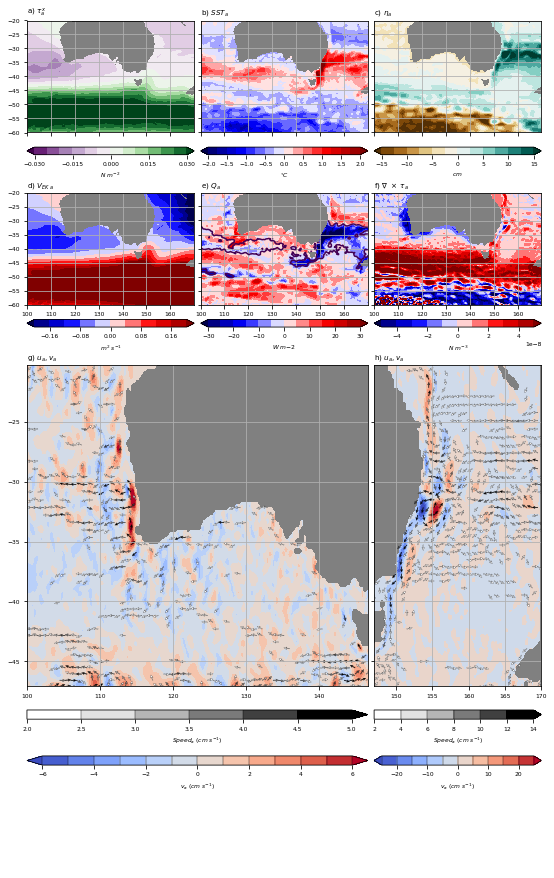

In [223]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)

fig = plt.figure() 
fig.set_size_inches(7.5,12)
matplotlib.rcParams.update({'font.size': 6}) 
col = 3
row = 5

ax = plt.subplot2grid((row, col), (0, 0), rowspan=1, colspan=1)
cont_lev = arange(-0.03,0.03,0.005)
anom = tau_x_rcp85 - tau_x_hist5069
contf = anom.plot.contourf(add_colorbar=True, levels=cont_lev, cmap=plt.cm.PRGn, extend='both',
                          cbar_kwargs={'ticks': [-0.03, -0.015, 0, 0.015, 0.03],
                                      'orientation':'horizontal',
                                      'label': r'$N\ m^{-2}$', 'pad':0.1})
plt.grid()
plt.title(r'a) $\tau^{x}_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_xticks(arange(100,160,10))
plt.gca().set_xticklabels('')
ax.set_facecolor('gray')



ax = plt.subplot2grid((row, col), (0, 1), rowspan=1, colspan=1)
cont_lev = arange(-2,2,0.25)
anom = SST_rcp85 - SST_hist5069
contf = anom.plot.contourf(add_colorbar=True, levels=cont_lev, cmap=plt.cm.seismic, extend='both',
                          cbar_kwargs={'orientation':'horizontal',
                                      'label': r'$^{\circ}C$', 'pad':0.1})
plt.title('')
plt.grid()
plt.title('b) $SST_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.gca().set_xticks(arange(100,160,10))
plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')



ax = plt.subplot2grid((row, col), (0, 2), rowspan=1, colspan=1)
cont_lev = arange(-15,15,2.5)
anom = sea_level_rcp85 - sea_level_hist5069
contf = anom.plot.contourf(add_colorbar=True, levels=cont_lev, cmap=plt.cm.BrBG, extend='both',
                          cbar_kwargs={'orientation':'horizontal',
                                      'label': r'$cm$', 'pad':0.1})
plt.title('')
plt.grid()
plt.title(r'c) $\eta_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_xticks(arange(100,160,10))
plt.gca().set_xticklabels('')
ax.set_facecolor('gray')
plt.gca().set_yticklabels('')



ax = plt.subplot2grid((row, col), (1, 0), rowspan=1, colspan=1)
cont_lev = arange(-0.2,0.2,0.04)
anom = V_ek_rcp85 - V_ek_hist5069
contf = anom.plot.contourf(add_colorbar=True, levels=cont_lev, cmap=plt.cm.seismic, extend='both',
                          cbar_kwargs={'orientation':'horizontal',
                                      'label': r'$m^{2}\ s^{-1}$', 'pad':0.1})
plt.title('')
plt.grid()
plt.title(r'd) $V_{EK\ a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.gca().set_xticks(arange(100,160,10))
# plt.gca().set_xticklabels('')
# plt.gca().set_yticklabels('')



ax = plt.subplot2grid((row, col), (1, 1), rowspan=1, colspan=1)
cont_lev = arange(-30,30,5)
anom = net_sfc_heating_rcp85 - net_sfc_heating_hist5069
contf = anom.plot.contourf(add_colorbar=True, levels=cont_lev, cmap=plt.cm.seismic, extend='both',
                          cbar_kwargs={'orientation':'horizontal',
                                      'label': r'$W\ m{-2}$', 'pad':0.1})
plt.contour(SST_rcp85.xt_ocean, SST_rcp85.yt_ocean, SST_rcp85 - SST_hist5069, 
            levels=[0.25], linewidth=1, color='k')
plt.title('')
plt.grid()
plt.title(r'e) $Q_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.gca().set_xticks(arange(100,160,10))
# plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')



ax = plt.subplot2grid((row, col), (1, 2), rowspan=1, colspan=1)
cont_lev = arange(-0.00000005,0.00000005,0.00000001)
anom = tau_curl_rcp85 - tau_curl_hist5069
contf2 = anom.plot.contourf(add_colorbar=True, levels=cont_lev, cmap=plt.cm.seismic, extend='both',
                          cbar_kwargs={'orientation':'horizontal',
                                      'label': r'$N\ m^{-3}$', 'pad':0.1})
plt.title('')
plt.grid()
plt.title(r'f) $\nabla\ \times\ \tau_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_xticks(arange(100,160,10))
# plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')
ax.set_facecolor('gray')



ax = plt.subplot2grid((row, col), (2, 0), rowspan=2, colspan=2)
cont_lev = arange(-6, 6, 1)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [100, 147]
Y_LIM = [-47, -20]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Y = v_anom.yu_ocean[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
U = np.array(u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
V = np.array(v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
contf = plt.contourf(X, Y, V, add_colorbar=False, levels=cont_lev, cmap=plt.cm.coolwarm, extend='both')
plt.title('')
n = 3

speed = np.sqrt(U**2 + V**2)
U1 = cp(U)
V1 = cp(V)
U2 = U / speed
V2 = V / speed
tol = 2
U1[speed > tol] = np.NaN
V1[speed > tol] = np.NaN
U1[speed < 1.5] = np.NaN
V1[speed < 1.5] = np.NaN
U2[speed < tol] = np.NaN
V2[speed < tol] = np.NaN
speed2 = cp(speed)
speed2[speed < tol] = np.NaN

vmin=tol
vmax=5
step=6
Q_lev = np.linspace(vmin, vmax, step+1)
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap = matplotlib.colors.ListedColormap(plt.cm.Greys(np.linspace(0,1,step)), "name")

# print(X.shape)
# print(Y.shape)
# print(U1.shape)
# print(V1.shape)
# print(U2.shape)
# print(V2.shape)
# print(speed.shape)

# Q1 = plt.quiver(X[0:188:n], 
#                 Y[0:132:n], 
#                 U1[0:132:n, 0:188:n], 
#                 V1[0:132:n, 0:188:n],
#                 width=0.0015, scale=100,
#                 headwidth=4.5, headaxislength=3.75, 
#                 facecolor='w', edgecolor='k', linewidth=0.2)

Q2 = plt.quiver(X[0:188:n], 
                Y[0:132:n], 
                U2[0:132:n, 0:188:n], 
                V2[0:132:n, 0:188:n],
                speed2[0:132:n, 0:188:n],
                cmap=cmap, norm=norm,
                width=0.0017, scale=60,
                headwidth=4.5, headaxislength=3.75, 
                edgecolor='k', linewidth=0.2)

plt.grid()
plt.title('g) $u_{a},v_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
ax = plt.subplot2grid((row, col), (4, 0), rowspan=1, colspan=2)
ax_divider = make_axes_locatable(ax)
cax1 = ax_divider.append_axes("top", size="10%", pad="2%")
cbar = plt.colorbar(contf, cax=cax1, orientation='horizontal', drawedges=True)
cbar.set_label(r'$v_{a}$ ($cm\ s^{-1}$)') 
cax2 = ax_divider.append_axes("top", size="10%", pad="40%")
cbar = plt.colorbar(Q2, cax=cax2, orientation='horizontal', drawedges=True, extend='max')
cbar.set_ticks(Q_lev)
cbar.set_label(r'$Speed_{a}$ ($cm\ s^{-1}$)')
ax.axis('off')


ax = plt.subplot2grid((row, col), (2, 2), rowspan=2, colspan=1)
cont_lev = arange(-25, 25, 5)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [147, 170]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
U = np.array(u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
V = np.array(v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
contf = plt.contourf(X, Y, V, add_colorbar=False, levels=cont_lev, cmap=plt.cm.coolwarm, extend='both')
plt.title('')
n = 3

speed = np.sqrt(U**2 + V**2)
U1 = cp(U)
V1 = cp(V)
U2 = U / speed
V2 = V / speed
tol = 2
U1[speed > tol] = np.NaN
V1[speed > tol] = np.NaN
U1[speed < 1.5] = np.NaN
V1[speed < 1.5] = np.NaN
U2[speed < tol] = np.NaN
V2[speed < tol] = np.NaN
speed2 = cp(speed)
speed2[speed < tol] = np.NaN

print(X.shape)
print(Y.shape)
print(U1.shape)
print(V1.shape)
print(U2.shape)
print(V2.shape)
print(speed.shape)

vmin=tol
vmax=14
step=6
Q_lev = np.linspace(vmin, vmax, step+1)
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap = matplotlib.colors.ListedColormap(plt.cm.Greys(np.linspace(0,1,step)), "name")

# Q1 = plt.quiver(X[0:72:n], 
#                 Y[0:132:n], 
#                 U1[0:132:n, 0:72:n], 
#                 V1[0:132:n, 0:72:n],
#                 norm=norm,
#                 width=0.0015, scale=100,
#                 headwidth=4.5, headaxislength=3.75, 
#                 facecolor='w', edgecolor='k', linewidth=0.2)

Q2 = plt.quiver(X[0:92:n], 
                Y[0:132:n], 
                U2[0:132:n, 0:92:n], 
                V2[0:132:n, 0:92:n],
                speed2[0:132:n, 0:92:n],
                cmap=cmap, norm=norm,
                width=0.0035, scale=30,
                headwidth=4.5, headaxislength=3.75, 
                edgecolor='k', linewidth=0.2)

plt.grid()
plt.title('h) $u_{a},v_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.xticks(arange(150,170,5))
plt.gca().set_yticklabels('')
ax.set_facecolor('gray')
ax = plt.subplot2grid((row, col), (4, 2), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax1 = ax_divider.append_axes("top", size="10%", pad="2%")
cbar = plt.colorbar(contf, cax=cax1, orientation='horizontal', drawedges=True)
cbar.set_label(r'$v_{a}$ ($cm\ s^{-1}$)') 
cax2 = ax_divider.append_axes("top", size="10%", pad="40%")
cbar = plt.colorbar(Q2, cax=cax2, orientation='horizontal', drawedges=True, extend='max')
cbar.set_ticks(Q_lev)
cbar.set_label(r'$Speed_{a}$ ($cm\ s^{-1}$)')
ax.axis('off')




fig.tight_layout(pad=0, w_pad=-2.5, h_pad=-0.5)

output_ls = os.listdir(figures_path)
if not script_name:
    script_name = 'test'
elif script_name not in output_ls:
    os.mkdir(figures_path + '/' + script_name)
plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
            + '_fig1_.png', bbox_inches='tight', dpi=300)